# Theoretische Grundlagen
Durch die Digitalisierung stieg die Anzahl von digitalen Texten drastisch an und steigt immer noch an, sodass diese kaum noch zu fassen sind. So umfasst das Deutsche Textarchiv (digitale Textsammlung) um die 145 Millionen Texte.
Diese Masse an Texten muss verwaltet werden, sodass Texte gefunden und abgebildet werden können. Des Weiteren müssen sie mit Unterstützung von Computern ausgewertet werden können, da dies manuell kaum machbar wäre.
Im Jahr 2007 beschäftigte sich Franco Moretti innerhalb seines Forschungsprogramms damit, tausend Werke der Weltliteratur gleichzeitig miteinander zu vergleichen. Möglich war dies aber nur mithilfe von (text-) statischen Verfahren und mit computergestützten Visualisierungen. (Heyer, Wiedemann, Niekler 2020, S.351-353)

# Topic Modeling
Topic Modelling ist eine bekannte Klasse dieser statischen Verfahren. Hierbei können große Datenmengen/Textmengen automatisch in Themenbereiche aufgeteilt werden. Es wird davon ausgegangen, dass jede Wortform zu einem Themenbereich (Topic) gehört. Durch die Untersuchung der Verteilung von zusammengehörigen Wortformen in einem Text sollen die Themenbereiche dieses Textes abgeleitet werden können.
Hiermit ist das Klassifizieren und Zusammenfassen von Texten und deren Abschnitten möglich. (Heyer, Wiedemann, Niekler 2020, S.351-353)

# Stärke und Schwächen
Stärken sind demnach die Unterteilung in Themen von großen Texten.
Eine Stärke ist ebenfalls die Tatsache, dass dies voll automatisch geschieht.
Nachteil ist, dass Syntax-Strukturen, Regelmäßigkeiten der Aussagen und weitere Informationen nicht aus dem Topic Modelling resultieren.
Dennoch kann Topic Modelling als Vorarbeit für die weitergehenden Untersuchungen genutzt werden. (Heyer, Wiedemann, Niekler 2020, S.351-353)


# Step 0: Libraries importieren

In [1]:
# The Basics
import pandas as pd
import numpy
from pprint import pprint

In [2]:
# The Preprocessing
import re
import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/niklaselsasser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/niklaselsasser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/niklaselsasser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# The Modell
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel

# Step 1: Das Dataframe (be)laden

In [5]:
#code necessary when running in colab
#from google.colab import drive
#drive.mount('/content/drive')

In [7]:
#code necessary when running in colab
import json
import pandas as pd

dataset_path = "News_Category_Dataset_v3.json"

with open(dataset_path, 'r') as file:
    news_data = [json.loads(line) for line in file]

df = pd.DataFrame(news_data)

In [8]:
#code necessary when running locally
df = pd.read_json("News_Category_Dataset_v3.json", lines=True)

# Step 2: Data Cleansing

In [9]:
df.drop(columns=["link", "authors", "date"], inplace=True)
df.head()

,headline,category,short_description
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha..."
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to..."
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...


Auf den ersten Blick können wir erkennen, dass die Kategorie "U.S. NEWS" eher ein mix aus unterschiedlichen Themen ist.
<br>Das könnte später unseren Algorithmus verwirren, weshalb wir Kategorien welche aus unterschiedlichen Themen bestehen, entfernen wollen.

In [10]:
df.category.unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
       'FIFTY', 'ARTS', 'DIVORCE'], dtype=object)

Kategorien welche wahrscheinlich mehrere Themen umfassen werden erfasst. Im unteren Sample können wir erkennen, dass unsere These korrekt ist.

In [11]:
df[df["category"].isin(["U.S. NEWS", "WORLD NEWS", "WEIRD NEWS", "THE WORLDPOST", "WORLDPOST"])].sample(5, random_state=0)

,headline,category,short_description
4996,93-Year-Old Woman Goes Viral When She Tells In...,WEIRD NEWS,"On Monday, Coors Light dropped off 150 cans of..."
6399,Shooting At Brooklyn Community Event Leaves 1 ...,U.S. NEWS,New York City Mayor Bill de Blasio vowed to “d...
74496,Woman Accused Of Commandeering Bus After Drive...,WEIRD NEWS,She didn't get very far.
24611,Now I Know What Fear Is,WORLD NEWS,"Everywhere I looked on my way home, someone wa..."
127331,Reinventing Europe Along These 7 Points,WORLDPOST,"In its present form, the EU is weak, particula..."


Was auch ins Auge fällt, ist Zeile `74496`. Ihre short_description ist zu kurz um daraus einen wertvollen Einblick zu erhalten. Das merken wir uns für später ;)

In [12]:
# Removal of useless categories
df = df[~df["category"].isin(["U.S. NEWS", "WORLD NEWS", "WEIRD NEWS", "THE WORLDPOST", "WORLDPOST"])]

In [13]:
unique_categories = len(df.category.unique())
print(f"{unique_categories=}")

unique_categories=37


Wir haben die alten Kategorien entfernt und sind jetzt bei schlanken 37 Kategorien.
<br>Als nächstes bereiten wir den Text aus der Überschrift und der Beschreibung etwas auf.
<br>Dazu entfernen wir alle Interpunktierung, Stoppwörter, Sonderzeichen und sorgen dafür, dass alle Buchstaben klein geschrieben sind.

In [14]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)

    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

Ein Beispiel wie diese Textaufbereitung funktiniert und was sie zurückgibt, findet sich in der unteren Zelle

In [15]:
print(preprocess_text("This is a very important text mentioning the President, the Health Department and Germany"), sep=" ")

['important', 'text', 'mentioning', 'president', 'health', 'department', 'germany']


In [16]:
# Apply preprocessing to the headlines and short descriptions
df['processed_text'] = df.apply(lambda row: preprocess_text(row['headline'] + ' ' + row['short_description']), axis=1)

# Filter out empty processed_text
processed_df = df[df['processed_text'].apply(len) > 0]

# Inspect the processed text
print(processed_df[['category', 'processed_text']].head())

          category                                     processed_text
2           COMEDY  [23, funniest, tweet, cat, dog, week, sept, 17...
3        PARENTING  [funniest, tweet, parent, week, sept, 1723, ac...
8   CULTURE & ARTS  [new, documentary, capture, complexity, child,...
13            TECH  [twitch, ban, gambling, site, streamer, scam, ...
16  CULTURE & ARTS  [reboot, clever, navelgazey, look, inside, tv,...


In [17]:
# Overview over preprocessed text
processed_df[['short_description', 'processed_text']].sample(5)

,short_description,processed_text
136549,This color also looks fantastic as it reflects...,"[stunning, home, exactly, paint, apartment, bl..."
33128,James’ LA home was recently the target of a ha...,"[lebrons, legacy, marred, america, ugly, racis..."
146858,But it gets even better -- LaBarre was savvy e...,"[man, marriage, proposal, cute, word, sings, i..."
187858,In the mood for chocolate? Try these cake reci...,"[chocolatecovered, strawberry, chocolate, bar,..."
17544,"""We are all Dreamers.""","[britney, spear, wear, slogan, tshirt, support..."


In [18]:
# Extract just the processed texts for future use
processed_texts = [doc["processed_text"] for _, doc in processed_df.iterrows()] 

# Step 3: Hilfsmittel für das LDA Model erstellen
Um das LDA Model später geordnet zu erzeugen, erstellen wir zwei Hilfsmittel.
### Dictionary: ID zu Wort
Corpora weißt jeden Wort eine eindeutige ID zu, mit welcher es später wieder erkannt werden kann.
<br>Dies hilft bei der schnellen und effizienten Verarbeitung der Wörter

### Liste: Korpus
Der Korpus listet für alle Dokumente einen Vektor welchen wir als "Bag of Words" bezeichnen.
<br>Er enthält alle Wörter und ihre Häufigkeit in dem Dokument. Über diesen Vektor, kann dem Dokument eine Bedeutung zugewiesen werden.

In [19]:
id2word = corpora.Dictionary(processed_texts)

corpus = [id2word.doc2bow(text) for text in processed_texts]

# Step 4: Das LDA Model trainieren
Das Latent Dirichlet Allocation (Latente Dirichlet Zuordnung (LDA)) Verfahren ist ein 3-stufiges Bayesian Model, um Topic Modeling durchzuführen (Blei et al.(2003)). Das Verfahren besteht aus den Teilen:
* **Latent:** Die Themen des Korpuses sind verborgen und müssen aus den Dokumenten und deren Wortverteilung abgeleitet werden (Blei et al. (2003), S. 1007).
* **Dirichlet:** Eine Verteilung, basierend auf dem Bayesian Modell, welche die Prioriverteilung (Anfangswahrscheinlichkeit) für die Themenverteilung in den Dokumenten darstellt und die Parameter beeinflussen wie stark bestimmte Themen in einem Dokument vertreten sind (Blei et al. (2003), S. 1007).
* **Allocation:** Die Prozess der Zuweisung und Verteilung beschreibt wie Wörter den verschiedenen Themen zugeordnet werden und wie die Themen in einem Dokument verteilt sind. Allocation beschreibt wie das Modell Wörter in einem Dokument aufgrund ihrer Wahrscheinlichkeit verschiedenen latenten Themen zugeordnet sind. Die Themen - Wörter verteilung in einem Dokument bildet die Grundlage der Analyse (Blei et al. (2003), S. 1007).

LDA nimmt an das es eine Themenverteilung für jeden Text gibt, welche berechnet wird indem ein Thema aus allen verfügbaren Themen $T={T_1,…,T_K}$ jedem Token ($≈$ Wort) eines Textes zugeordnet wird. Der Nutzer definiert dabei die Anzahl der modellierten Themen $K∈N$. Der Text (oder das Dokument) wird als Corpus bezeichnet und besteht aus Texten $M$ sowie Themen $T$ (Rieger at al. (2020 Juni), S. 120); Blei et al. (2003), S. 997).
Dabei ist $N^m$ die Größe des Textes und $W={W,…,W_V}$ die Menge der Wörter wobei $V∈N$ die Größe des implizierten Vokabulars (die Menge aller eindeutigen Wörter) ist(Rieger et al. (2020 Juni), S. 120).

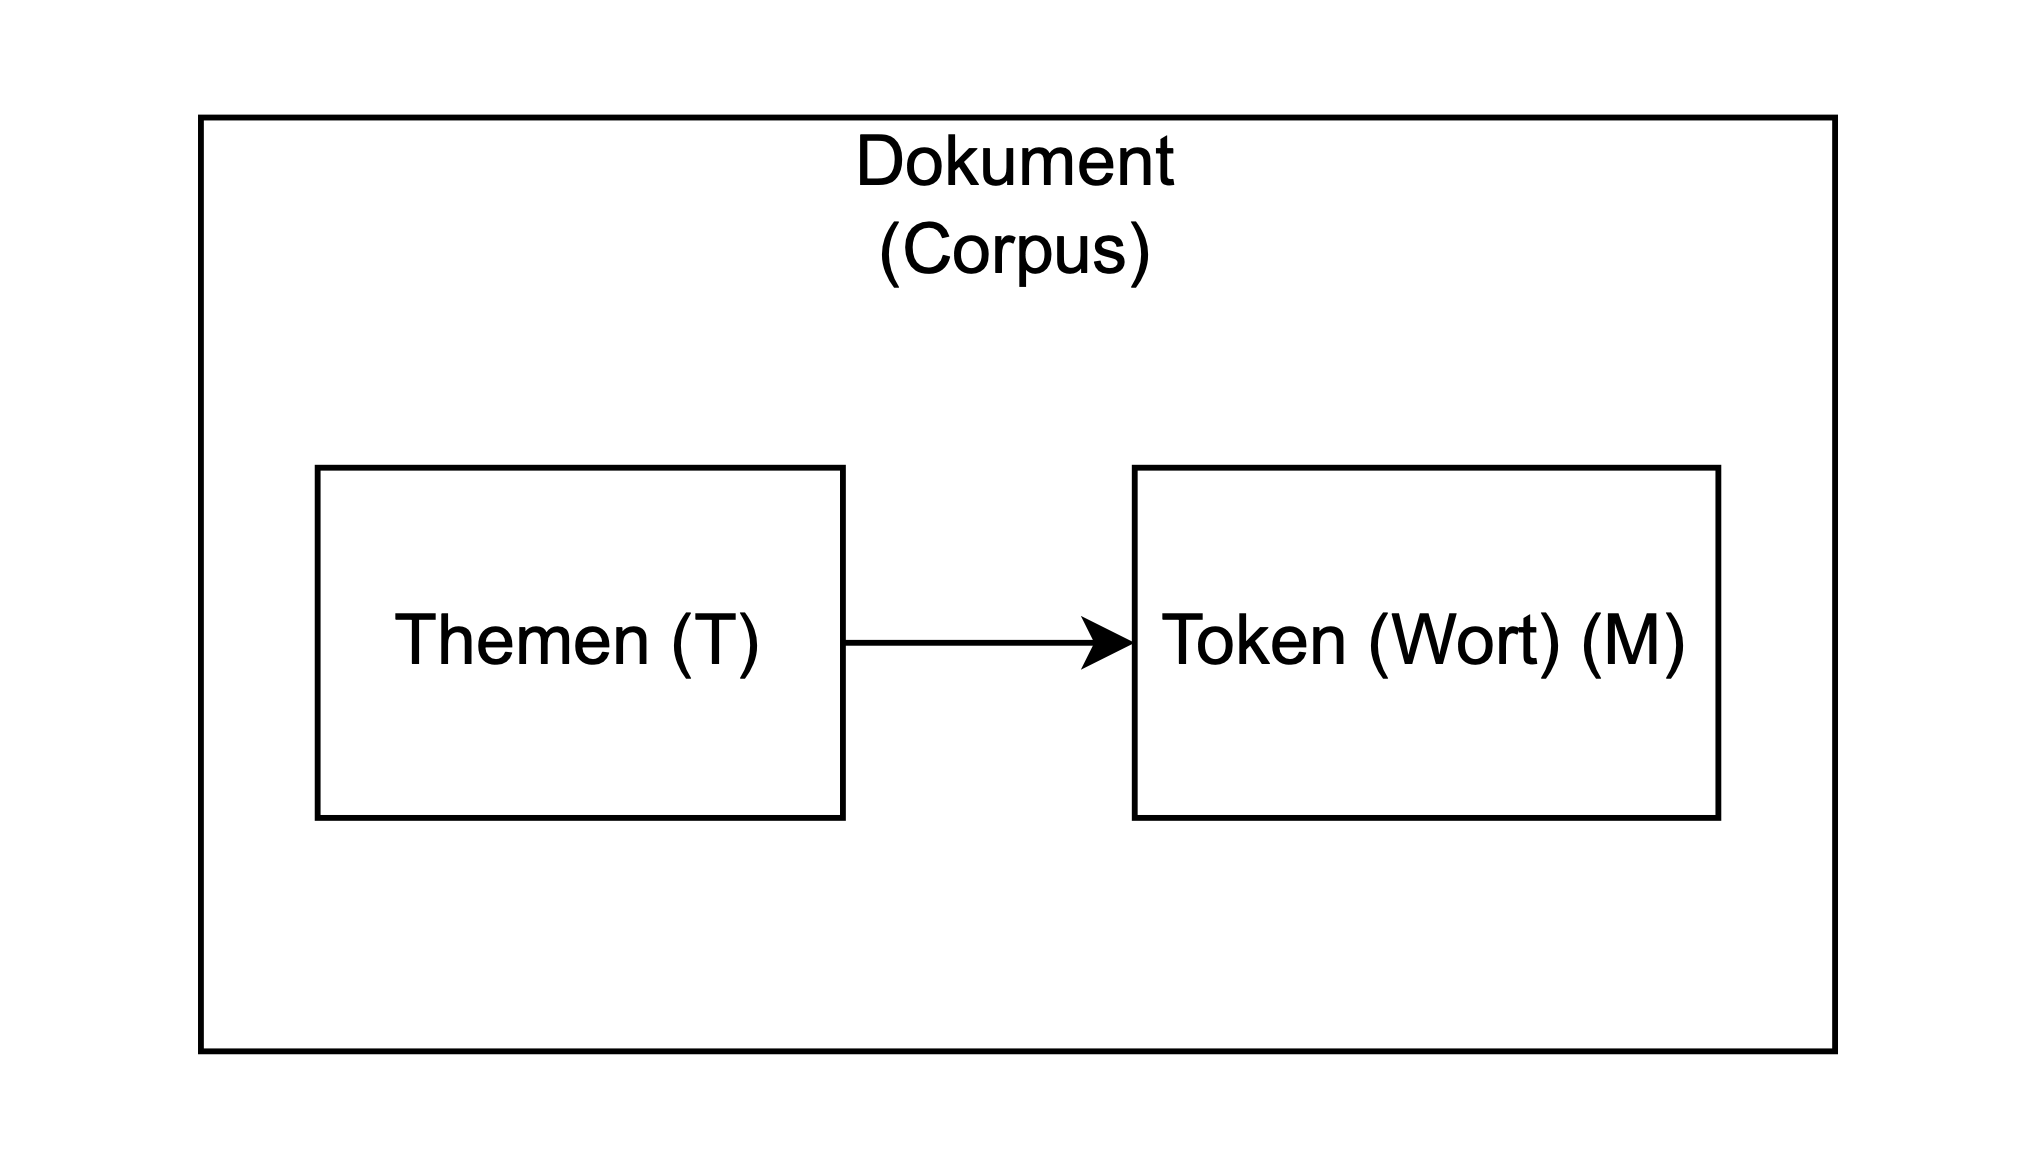


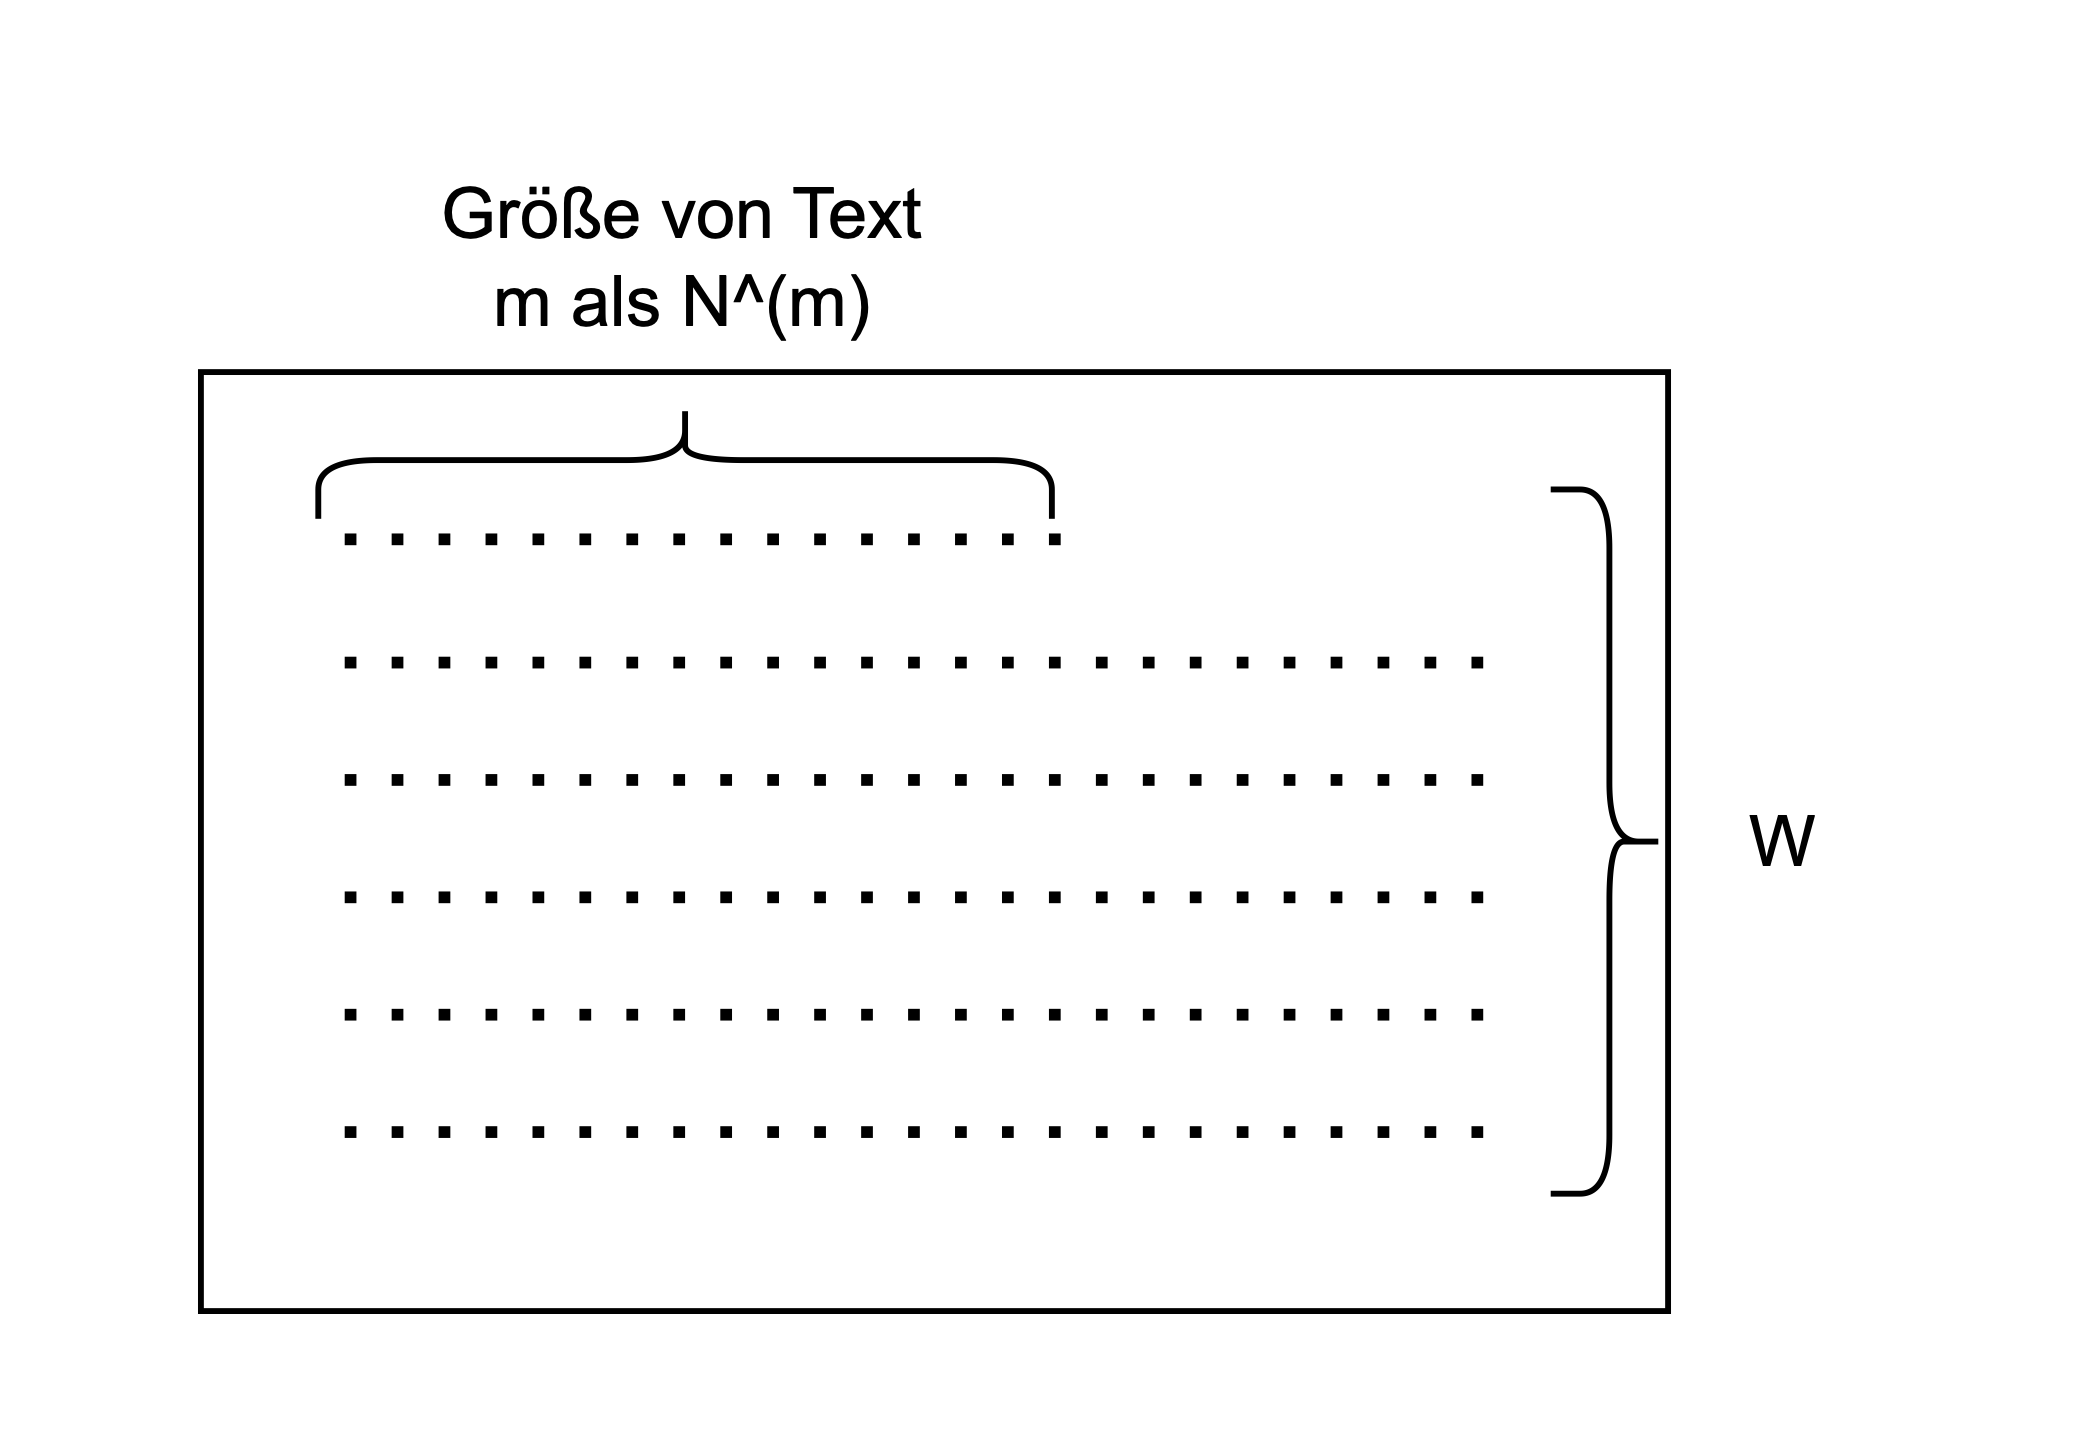

Somit besteht ein $**Dokument**$ aus:
$$D^((m))=(W_1^((m) ),…,W_(N^((m) ))^((m) ) ); m=1,…,M;W_n^((m) )∈W;n=1,…,N^m$$
Die Themenzuweisung für einen Text $m$ ist wie folgt:
$$T^((m) )=(T^((m)),…,T_(N^((m)))^((m)) ),T_n^((m))∈T$$
Jede Themenzuweisung $T_n^((m))$ hängt mit einem Token $W_n^((m))$ aus dem Text $m$ zusammen.

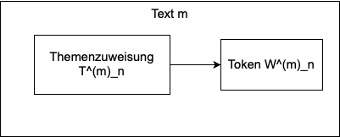

Um das Wahrscheinlichkeitsmodell für LDA aufzustellen sind folgende Definitionen und Annahmen notwendig: $n_k^((mv));k=1,…,K;v=1,…,V$ als Anzahl zugewiesener Wörter $v$ in Text $m$ zugehörig zu Thema $k$, dadurch lässt sich die Summe der Wörter $v$  in Thema $k$ über alle Dokumente $D$ mit $n_k^((*v))$ bestimmen. Wenn $w_k=(n_k^((*1)),…,n_k^((*V)) )^T$ die Vektoren der Wortanzahl für $k=1,…,K$ Themen ist, dann lässt sich mit diesen Definitionen das Modell wie folgt aufstellen:

$W_n^((m)) |T_n^((m)),ϕ_k  ~$ Discrete $(ϕ_k),		ϕ_k  ~$ Dirichlet $(η)$

$T_n^((m)) |θ_m  ~$ Discrete $(θ_m),		θ_m  ~$ Dirichlet $(α)$

Die Dirichlet Verteilungs Hyperparameter $α$ und $η$ müssen vom Nutzer deklariert werden. Da normalerweise keine a-priori (Anfangswahrscheinlichkeit) Informationen der Themen $θ$  und Wortverteilungen $ϕ$ vorliegen, werden $α$ und $η$ symmetrisch bestimmt (Rieger at al. (2020 Juni), S. 120).

Ein hoher $η$ Wert führt zu einem Verlust der Gleichmäßigkeit der Wortmischung pro Thema, ein niedriger $η$ Wert erhöht und verbessert die Gleichmäßigkeit wodurch weniger dominantere Wörter pro Thema zugeordnet werden. Nach dem gleichen Prinzip steuert α die Mischung der Themen in den Texten (Rieger at al. (2020 Juni), S. 120).

LDA ist eine Weiterentwicklung von LSI, bzw. pLSI, wobei LSI selbst eine Weiterentwicklung von tf-idf ist (Blei et al. (2003), S. 994). LSI verbessert tf-idf indem eine größere reduktion der Beschreibungslänge in großen Daten möglich ist und die statistische Struktur zwischen oder innerhalb von Dokumenten offenbart (Blei et al. (2003), S. 994; Rosario, B. (2000)). Probability LSI (pLSI) verbessert LSI dahingehend, dass alle Worte in einem Dokument eine Stichprobe aus einem Mischungsmodell sind in welchem wiederum verschiedene Themen Multinomial-Verteilungen abgebildet sind (Blei et al. (2003), S. 994). Durch die linearität des Modelles kommt es zu overfitting, zusätzlich gibt es keine Möglichkeit nicht im Training enthaltenen Dokumenten eine Wahrscheinlichkeit zuzuweisen (Blei et al. (2003), S. 994).
Um Repräsentationen von Dokumenten und Wörtern austauschbar abzubilden, ist es notwendig mixture-models zu verwenden und somit den angeführten Limitationen von LSI und verwandten Ansätzen zu entgehen (Blei et al. (2003), S. 995).

Außerdem grenzt sich LDA von Hierarchical Latent Tree Analysis (HLTA) wie folgt ab, HLTA stellt Koinzidenz Muster explizit in Modellstrukturen dar (Chen at al. (2017), S. 1). HLTA ist somit eine Methode um Themen zu erkennen, indem ein Thema anhand von Wörtern identifiziert wird, die häufig in einem Thema und selten in einem anderen Thema auftreten (Liu et al. (2014), S. 1).

Somit besteht ein $**Dokument**$ aus:
$$D^((m))=(W_1^((m) ),…,W_(N^((m) ))^((m) ) ); m=1,…,M;W_n^((m) )∈W;n=1,…,N^m$$
Die Themenzuweisung für einen Text $m$ ist wie folgt:
$$T^((m) )=(T^((m)),…,T_(N^((m)))^((m)) ),T_n^((m))∈T$$
Jede Themenzuweisung $T_n^((m))$ hängt mit einem Token $W_n^((m))$ aus dem Text $m$ zusammen.

Somit besteht ein **$Dokument$** aus:
$$D^m=(W_1^m,…,W_N^m); m=1,…,M;W_n^m ∈ W;n=1,…,N^m$$
Die Themenzuweisung für einen Text $m$ ist wie folgt:
$$T^((m) )=(T^((m)),…,T_(N^((m)))^((m)) ),T_n^((m))∈T$$
Jede Themenzuweisung $T_n^((m))$ hängt mit einem Token $W_n^((m))$ aus dem Text $m$ zusammen.

In [196]:
import time
start_time = time.time()
lda_model = LdaModel(corpus=corpus, id2word=id2word,
                    num_topics=unique_categories,
                    random_state=42,
                    passes=10,
                    alpha="auto",
                    per_word_topics=True)
stop_time = time.time()
run_time = stop_time - start_time
print("Wall time:", run_time/60, "m")

Wall time: 11.7227903008461 m


In [21]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=id2word, coherence="c_v")
coherence_lda = coherence_model_lda.get_coherence()
print("Coherence Score:", coherence_lda)

Coherence Score: 0.2474312675884771


In [197]:
data = {
    "lda_model_train_time_in_s": [run_time],
    "lda_model_coherence_score": [coherence_lda]
}
export_df = pd.DataFrame(data)
export_df.to_csv(r"data\vanilla_lda_data.csv", index=False)

# Step 4: Visualisierung mit pyLDAvis
Um zu visualisieren, wie unser LDA Model Wörter kategorisiert, nutzen wir die Library pyLDAvis.
<br>Mit ihr können wir uns einen interaktiven und intuitiven Überblick über unser Model verschaffen

In [22]:
import pyLDAvis
from pyLDAvis import gensim_models
pyLDAvis.enable_notebook()

In [23]:
visualisation = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

In [24]:
visualisation

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.391439  0.271625       1        1  19.044307
21    -0.185862 -0.368927       2        1   5.817402
20    -0.126254 -0.122822       3        1   4.294552
14    -0.053493 -0.031190       4        1   3.079454
9     -0.039575 -0.021187       5        1   3.011409
18    -0.074813 -0.049659       6        1   2.637729
2     -0.029502 -0.014856       7        1   2.525503
30     0.050215  0.018256       8        1   2.486119
26     0.018798  0.008132       9        1   2.460454
19    -0.001356 -0.000194      10        1   2.338877
22    -0.015651 -0.007259      11        1   2.326124
7      0.000281  0.000534      12        1   2.246707
13     0.042072  0.015993      13        1   2.213425
8     -0.004293 -0.001610      14        1   2.199525
24     0.009781  0.004618      15        1   2.181190
4      0.003089  0.001708      16        1   2.148110
34     0.013581  0.006009      17        1   2.137559
28     0.014273  0.006339      18        1   2.086219
3     -0.001144 -0.000139      19        1   2.043732
10     0.011837  0.005327      20        1   2.015435
16     0.034713  0.013634      21        1   1.981062
36     0.070505  0.023471      22        1   1.976422
32     0.024729  0.010227      23        1   1.970240
6      0.032853  0.013055      24        1   1.936066
27     0.035736  0.013915      25        1   1.935793
1      0.025500  0.010548      26        1   1.927282
35     0.034949  0.013671      27        1   1.906565
25     0.062600  0.021573      28        1   1.843949
17     0.041308  0.015655      29        1   1.831207
5      0.030817  0.012281      30        1   1.800527
29     0.047605  0.017540      31        1   1.761613
12     0.044499  0.016683      32        1   1.752952
15     0.061085  0.021229      33        1   1.725747
31     0.045612  0.016908      34        1   1.680242
33     0.041436  0.015726      35        1   1.635210
23     0.060912  0.021098      36        1   1.579821
0      0.064595  0.022091      37        1   1.461470, topic_info=         Term          Freq         Total Category  logprob  loglift
1564    photo  31543.000000  31543.000000  Default  30.0000  30.0000
145       day  22766.000000  22766.000000  Default  29.0000  29.0000
3310  wedding  10369.000000  10369.000000  Default  28.0000  28.0000
921      love  12076.000000  12076.000000  Default  27.0000  27.0000
104     world  10741.000000  10741.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
582     grand    489.041264    490.117854  Topic37  -4.6471   4.2235
4103  whitney    484.385737    485.462327  Topic37  -4.6567   4.2235
7507   period    483.955880    485.032469  Topic37  -4.6576   4.2235
174    aspect    446.094715    447.171305  Topic37  -4.7391   4.2233
2475  chronic    422.783977    423.860567  Topic37  -4.7927   4.2232

[1141 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
571      26  0.999316        1
212       2  0.999808       10
817      27  0.999221      100
590      12  0.999102       11
5244     11  0.998838       12
...     ...       ...      ...
2062     10  0.999308    youll
1575      3  0.999483    young
966       3  0.999878    youre
688      29  0.999360  youtube
7473      4  0.999540    youve

[1112 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 22, 21, 15, 10, 19, 3, 31, 27, 20, 23, 8, 14, 9, 25, 5, 35, 29, 4, 11, 17, 37, 33, 7, 28, 2, 36, 26, 18, 6, 30, 13, 16, 32, 34, 24, 1])

saving the pyldavis visual for later comparison in Benchmarks&Visualization (link)!

In [25]:
import pickle

In [26]:
with open('visuals/vanilla_lda.pkl', 'wb') as f:
    pickle.dump(visualisation, f)

# Literaturhinweise
* Rosario, B. (2000). Latent semantic indexing: An overview. Techn. rep. INFOSYS, 240, 1-16.
* Chen, P., Zhang, N. L., Liu, T., Poon, L. K., Chen, Z., & Khawar, F. (2017). Latent tree models for hierarchical topic detection. Artificial Intelligence, 250, 105-124.
* Liu, T., Zhang, N. L., & Chen, P. (2014). Hierarchical latent tree analysis for topic detection. In Machine Learning and Knowledge Discovery in Databases: European Conference, ECML PKDD 2014, Nancy, France, September 15-19, 2014. Proceedings, Part II 14 (pp. 256-272). Springer Berlin Heidelberg.
* Rieger, J., Rahnenführer, J., & Jentsch, C. (2020, June). Improving latent Dirichlet allocation: On reliability of the novel method LDAPrototype. In International conference on applications of natural language to information systems (pp. 118-125). Cham: Springer International Publishing.
* Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent dirichlet allocation. Journal of machine Learning research, 3(Jan), 993-1022.
* Schütze, H., Manning, C. D., & Raghavan, P. (2008). Introduction to information retrieval (Vol. 39, pp. 234-265). Cambridge: Cambridge University Press.
* Rieger, J., Koppers, L., Jentsch, C., Rahnenfu ̈hrer, J.: Improving Reliability of Latent Dirichlet Allocation by Assessing Its Stability Using Clustering Techniques on Replicated Runs (2020)
* Heyer, Gerhard, Wiedemann, Gregor, Niekler, Andreas (2020): Topic-Modelle und ihr Potenzial für die philologische Forschung, In Lobin, Henning, Schneider, Roman, Witt, Andreas (Hrsg.): Digitale Infrastrukturen für die germanistische Forschung (S.351-353), de Gruyter, 23.07.2018.
* Misra, Rishabh and Jigyasa Grover. "Sculpting Data for ML: The first act of Machine Learning." ISBN 9798585463570 (2021).